In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta

import os

# Sessions. Analysis of the user with the longest time gap between sessions

In [2]:
sessions = pd.read_csv('sessions.csv')

sessions

,user_id,event_datetime,duration_sec
0,1,2023-10-01 15:12:06,234
1,2,2023-10-01 23:43:17,187
2,2,2023-10-22 11:12:00,87
3,1,2023-11-15 15:12:24,3
4,1,2023-12-12 00:17:06,28
5,1,2023-12-14 00:25:06,465
6,3,2023-10-05 08:45:30,120
7,2,2023-11-01 14:22:10,300
8,3,2023-11-10 09:15:45,150
9,1,2023-11-20 16:30:00,200


In [3]:
# os.system("curl https://clickhouse.com/ | sh")

query = """

WITH

    src AS (
    
        SELECT
        
            user_id,
            
            event_datetime                                                 AS session_start,
            
            MAX(addSeconds(session_start, duration_sec))                   AS session_end,
            
            leadInFrame(event_datetime) OVER (
                PARTITION BY user_id
                ORDER BY event_datetime asc
                ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
            )                                                              AS next_session_start,
            
            next_session_start - session_end                               AS time_between_sessions
        
        FROM file('sessions.csv', CSVWithNames)                            AS sns
        
        WHERE duration_sec > 0 -- check for a legit session
        
        GROUP BY 1, 2
    ),

    final AS (
    
        SELECT
        
            user_id,

            MAX(time_between_sessions),                                   AS agg_tbs, 
            --MIN(time_between_sessions)                                  AS agg_tbs,
            --AVG(1.0 * time_between_sessions)                            AS agg_tbs,
            --MEDIAN(time_between_sessions)                               AS agg_tbs,
            --SUM(time_between_sessions)                                  AS agg_tbs,
            
            ROW_NUMBER() OVER(
                ORDER BY agg_tbs desc, user_id ASC
            )                                                             AS rn
        
        FROM src
        GROUP BY 1
    )

SELECT user_id
FROM final
WHERE rn = 1
FORMAT CSVWithNames
"""

cmd = """
./clickhouse local -q "
{}
"
""".format(query)

os.system(cmd)

1

# Anomalies. Analysis of cases involving issues with one or more payment methods

In [4]:
bills = pd.read_csv(
    'bills.csv')

bills.head()

,event_datetime,user_id,payment_method,country,amount,status
0,2022-12-01 00:00:00.000000000,9543706,card_processing,AE,10.90,success
1,2022-12-01 00:00:02.592002592,9835632,binance_pay,SA,71.43,cancel
2,2022-12-01 00:00:05.184005184,7526368,card_processing,SA,18.44,cancel
3,2022-12-01 00:00:07.776007776,4572510,card_processing,SA,40.91,cancel
4,2022-12-01 00:00:10.368010368,7832872,binance_pay,SA,23.00,cancel


In [5]:
bills = pd.read_csv(
    
    'bills.csv',
    
    parse_dates = ['event_datetime'],
    
    dtype = {
        'payment_method': 'category',
        'country': 'category',
        'status': 'category'
    }
)

bills.head()

,event_datetime,user_id,payment_method,country,amount,status
0,2022-12-01 00:00:00.000000000,9543706,card_processing,AE,10.90,success
1,2022-12-01 00:00:02.592002592,9835632,binance_pay,SA,71.43,cancel
2,2022-12-01 00:00:05.184005184,7526368,card_processing,SA,18.44,cancel
3,2022-12-01 00:00:07.776007776,4572510,card_processing,SA,40.91,cancel
4,2022-12-01 00:00:10.368010368,7832872,binance_pay,SA,23.00,cancel


In [6]:
bills.info() # No null values were detected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   event_datetime  1000000 non-null  datetime64[ns]
 1   user_id         1000000 non-null  int64         
 2   payment_method  1000000 non-null  category      
 3   country         1000000 non-null  category      
 4   amount          1000000 non-null  float64       
 5   status          1000000 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(1), int64(1)
memory usage: 25.8 MB


In [7]:
bills.describe()

,event_datetime,user_id,amount
count,1000000,1.000000e+06,1000000.000000
mean,2022-12-15 23:59:59.999995904,5.491539e+06,50.935791
min,2022-12-01 00:00:00,1.000021e+06,10.000000
25%,2022-12-08 12:00:00,3.251441e+06,14.390000
50%,2022-12-16 00:00:00,5.484437e+06,34.680000
75%,2022-12-23 12:00:00,7.725785e+06,69.400000
max,2022-12-31 00:00:00,9.999985e+06,815.130000
std,NaN,2.590692e+06,49.159379


In [8]:
bills.groupby('status', observed = False)['amount']\
     .describe()\
     .reset_index()

,status,count,mean,std,min,25%,50%,75%,max
0,cancel,495339.0,50.910096,49.249934,10.0,14.37,34.64,69.34,815.13
1,pending,156473.0,51.002809,49.126434,10.0,14.39,34.82,69.65,622.05
2,success,348188.0,50.942226,49.045215,10.0,14.42,34.68,69.39,811.84


- Payment amounts are statistically very similar across all statuses;

- The only meaningful difference is that large payments do not remain pending

In [9]:
bills.groupby('payment_method', observed = False)['amount']\
     .describe()\
     .reset_index()

,payment_method,count,mean,std,min,25%,50%,75%,max
0,binance_pay,184078.0,51.005748,49.378256,10.0,14.3700,34.650,69.5000,700.36
1,card_processing,547390.0,50.877178,49.069210,10.0,14.4000,34.670,69.2700,815.13
2,jazzcash,57885.0,50.969278,49.336681,10.0,14.4100,34.630,69.3700,591.93
3,nagad,32965.0,50.950174,49.148393,10.0,14.3000,34.740,69.3800,456.98
4,paytm,32736.0,50.957367,49.051354,10.0,14.4000,34.805,69.6900,622.05
5,pix,26950.0,51.337406,49.654032,10.0,14.4100,34.830,69.9700,526.34
6,skrill,99472.0,50.947755,49.057809,10.0,14.4275,34.800,69.5000,583.69
7,upi,18524.0,51.155713,49.123222,10.0,14.3000,34.610,70.4625,496.68


- Payment amount distributions are consistent across all payment methods, indicating no meaningful relationship between transaction size and the choice of payment method; 

- All payment methods share the same minimum amount;

- But differences appear only in the upper tail (max). Traditional card payments handle the largest transactions while alternative (or local) payment methods are used for smaller maximum amounts

In [10]:
bills.groupby('country', observed = False)['amount']\
     .describe()\
     .reset_index()

,country,count,mean,std,min,25%,50%,75%,max
0,AE,200510.0,50.873197,48.969078,10.0,14.3600,34.60,69.4600,583.22
1,BD,79526.0,50.991196,49.398827,10.0,14.3100,34.59,69.2975,700.36
2,BR,50947.0,51.249549,49.650889,10.0,14.4700,34.89,69.7450,556.75
3,IN,99048.0,50.855936,48.879063,10.0,14.3400,34.63,69.4925,811.84
4,PK,119387.0,50.907120,49.213584,10.0,14.3700,34.64,69.3800,606.68
5,SA,400128.0,50.961179,49.200333,10.0,14.4100,34.74,69.3500,815.13
6,TR,30176.0,50.953652,49.407529,10.0,14.5300,34.62,69.5300,542.41
7,ZA,20278.0,50.580435,48.724144,10.0,14.3825,34.71,68.8700,539.65


- Typical transaction sizes are nearly identical across all countries. This suggests strong global price standardization or similar user behavior across markets;

- Minimum value across all countries are identical. This indicates a global minimum payment amount enforced by the system, or a product-level pricing constraint;

- Maximum values vary by country: 1) highest max values: SA ~ 815, IN ~ 812, BD ~ 700; 2) lower max values: AE, BR, TR, ZA ~ 530-580. Some markets support higher-value transactions (likely due to user purchasing power, local payment infrastructure or regulatory limits), however, these differences affect only a very small fraction of transactions

In [11]:
bills['event_date'] = bills['event_datetime'].dt.date

In [12]:
bills['event_date'].value_counts().sort_index()

event_date
2022-12-01    33334
2022-12-02    33333
2022-12-03    33333
2022-12-04    33334
2022-12-05    33333
2022-12-06    33333
2022-12-07    33334
2022-12-08    33333
2022-12-09    33333
2022-12-10    33333
2022-12-11    33334
2022-12-12    33333
2022-12-13    33333
2022-12-14    33334
2022-12-15    33333
2022-12-16    33333
2022-12-17    33334
2022-12-18    33333
2022-12-19    33333
2022-12-20    33333
2022-12-21    33334
2022-12-22    33333
2022-12-23    33333
2022-12-24    33334
2022-12-25    33333
2022-12-26    33333
2022-12-27    33334
2022-12-28    33333
2022-12-29    33333
2022-12-30    33333
2022-12-31        1
Name: count, dtype: int64

In [13]:
bills.loc[bills['event_date'] == date(2022, 12, 31), :]

,event_datetime,user_id,payment_method,country,amount,status,event_date
999999,2022-12-31,4105705,card_processing,SA,129.44,success,2022-12-31


In [14]:
bills_30 = bills.loc[bills['event_date'] == date(2022, 12, 30), :].sort_values('event_datetime')

In [15]:
bills_30.head()

,event_datetime,user_id,payment_method,country,amount,status,event_date
966666,2022-12-30 00:00:00.777600777,7915968,binance_pay,PK,10.00,cancel,2022-12-30
966667,2022-12-30 00:00:03.369603369,3510853,card_processing,SA,23.59,cancel,2022-12-30
966668,2022-12-30 00:00:05.961605961,9435216,card_processing,SA,10.00,success,2022-12-30
966669,2022-12-30 00:00:08.553608553,4494745,card_processing,AE,28.64,cancel,2022-12-30
966670,2022-12-30 00:00:11.145611145,9908360,card_processing,AE,14.76,success,2022-12-30


In [16]:
bills_30.tail()

,event_datetime,user_id,payment_method,country,amount,status,event_date
999994,2022-12-30 23:59:47.039987040,4434027,card_processing,SA,44.87,cancel,2022-12-30
999995,2022-12-30 23:59:49.631989632,9064597,card_processing,SA,43.76,success,2022-12-30
999996,2022-12-30 23:59:52.223992224,3323918,pix,BR,159.32,success,2022-12-30
999997,2022-12-30 23:59:54.815994816,9937162,skrill,SA,127.25,pending,2022-12-30
999998,2022-12-30 23:59:57.407997408,9489398,card_processing,SA,10.00,cancel,2022-12-30


In [17]:
# daily time series metrics

bills_ts = bills.copy()

bills_ts['date'] = bills_ts['event_datetime'].dt.floor('D')

daily = (bills_ts
         .groupby('date')\
         .agg(
             payments_cnt = ('amount', 'size'),
             amount_sum = ('amount', 'sum'),
             amount_mean = ('amount', 'mean'),
             success_cnt = ('status', lambda x: (x == 'success').sum()),
         )
         .sort_index())

daily['success_rate'] = daily['success_cnt'] / daily['payments_cnt']

daily.head()

,payments_cnt,amount_sum,amount_mean,success_cnt,success_rate
date,,,,,
2022-12-01,33334,1691082.93,50.731473,11560,0.346793
2022-12-02,33333,1705182.24,51.155979,11567,0.347013
2022-12-03,33333,1693786.44,50.814101,11632,0.348963
2022-12-04,33334,1703031.54,51.089924,11544,0.346313
2022-12-05,33333,1703258.65,51.098270,11564,0.346923


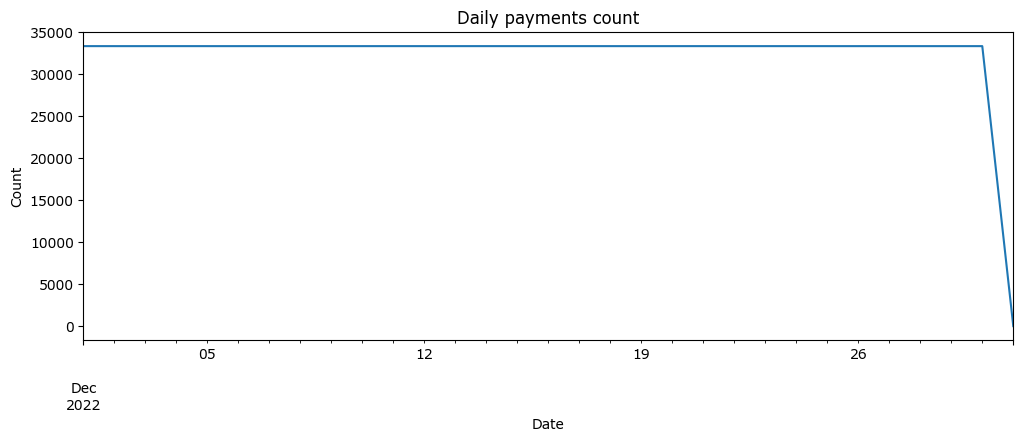

In [18]:
fig, ax = plt.subplots(figsize = (12, 4))
daily['payments_cnt'].plot(ax = ax)
ax.set_title("Daily payments count")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
plt.show()

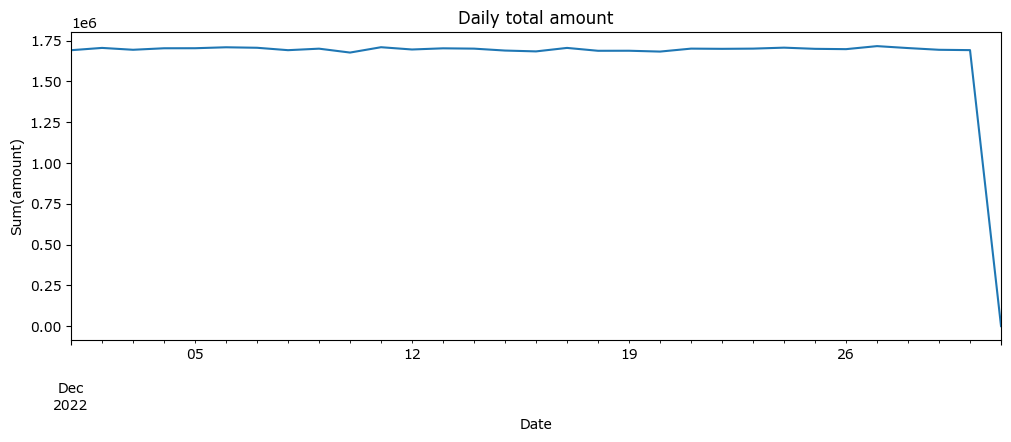

In [19]:
fig, ax = plt.subplots(figsize = (12, 4))
daily['amount_sum'].plot(ax = ax)
ax.set_title("Daily total amount")
ax.set_xlabel("Date")
ax.set_ylabel("Sum(amount)")
plt.show()

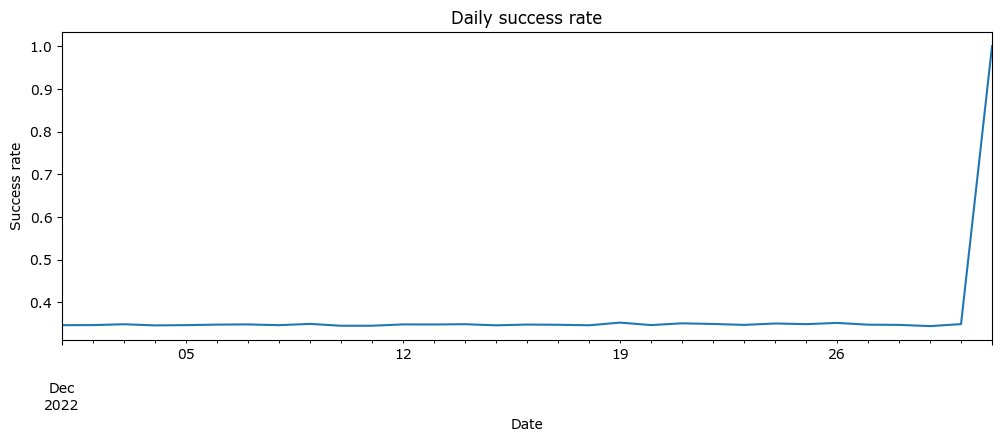

In [20]:
fig, ax = plt.subplots(figsize = (12, 4))
daily['success_rate'].plot(ax = ax)
ax.set_title("Daily success rate")
ax.set_xlabel("Date")
ax.set_ylabel("Success rate")
plt.show()

In [21]:
# anomaly detection algorithm: rolling z-score on residuals

def rolling_zscore(series: pd.Series, window: int = 14):
    mean = series.rolling(window, min_periods = window).mean()
    std = series.rolling(window, min_periods = window).std(ddof = 0)
    z = (series - mean) / std
    return z

WINDOW = 14
THRESH = 3.0

daily['z_cnt'] = rolling_zscore(daily['payments_cnt'], WINDOW)
daily['z_sum'] = rolling_zscore(daily['amount_sum'], WINDOW)
daily['z_sr']  = rolling_zscore(daily['success_rate'], WINDOW)

# Flag anomalies (3 separate signals)
daily['anomaly_cnt'] = daily['z_cnt'].abs() > THRESH
daily['anomaly_sum'] = daily['z_sum'].abs() > THRESH
daily['anomaly_sr']  = daily['z_sr'].abs()  > THRESH

# Combine (any signal)
daily['anomaly_any'] = daily[['anomaly_cnt','anomaly_sum','anomaly_sr']].any(axis = 1)

daily[daily['anomaly_any']].sort_index()

,payments_cnt,amount_sum,amount_mean,success_cnt,success_rate,z_cnt,z_sum,z_sr,anomaly_cnt,anomaly_sum,anomaly_sr,anomaly_any
date,,,,,,,,,,,,
2022-12-31,1,129.44,129.44,1,1.0,-3.605551,-3.604898,3.605245,True,True,True,True


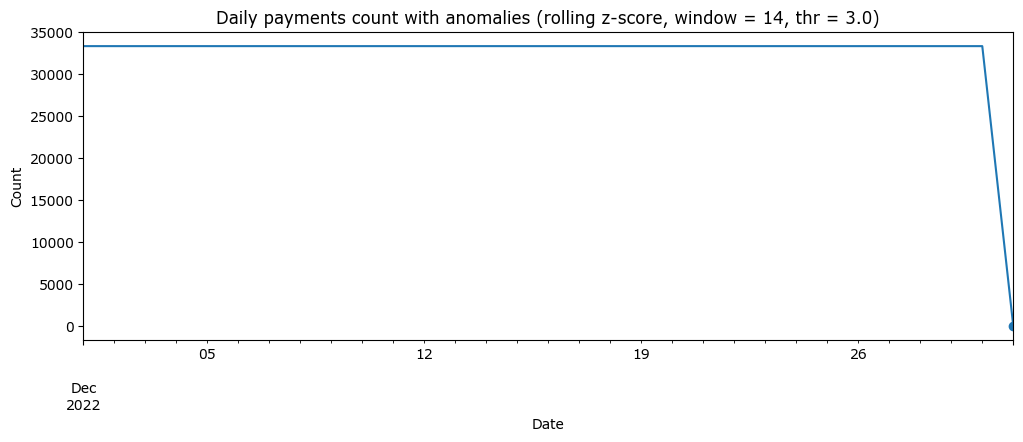

In [22]:
# anomalies on the count series (with markers)
fig, ax = plt.subplots(figsize = (12, 4))
daily['payments_cnt'].plot(ax = ax)
ax.scatter(
    daily.index[daily['anomaly_cnt']],
    daily.loc[daily['anomaly_cnt'], 'payments_cnt'],
)
ax.set_title(f"Daily payments count with anomalies (rolling z-score, window = {WINDOW}, thr = {THRESH})")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
plt.show()

**The issue seems to have occurred on 2022-12-31; the lone record at 00:00:00 likely corresponds to the previous day.**

In [23]:
status_order = ['cancel', 'pending', 'success']

# counts by (payment_method, country, status)
g = (
 bills.groupby(['payment_method', 'country', 'status'], observed = False)
      .size()
      .rename('n')
      .reset_index()
)

# pivot to wide
pivot = (
    g.pivot_table(index = ['payment_method', 'country'],
                  columns = 'status',
                  values = 'n',
                  fill_value = 0,
                  aggfunc = 'sum',
                  observed = False)
    .reindex(columns = status_order, fill_value = 0)
)

pivot['total'] = pivot.sum(axis = 1)

# rates
for s in status_order:
    pivot[f'{s}_rate'] = pivot[s] / pivot['total']

pivot = pivot.reset_index()

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pivot)

status,payment_method,country,cancel,pending,success,total,cancel_rate,pending_rate,success_rate
0,binance_pay,AE,46882,0,0,46882,1.000000,0.000000,0.000000
1,binance_pay,BD,9781,16,1089,10886,0.898493,0.001470,0.100037
2,binance_pay,BR,5063,6,516,5585,0.906535,0.001074,0.092390
3,binance_pay,IN,0,0,0,0,NaN,NaN,NaN
4,binance_pay,PK,13235,19,1361,14615,0.905576,0.001300,0.093124
5,binance_pay,SA,84801,123,9127,94051,0.901649,0.001308,0.097043
6,binance_pay,TR,6522,8,646,7176,0.908863,0.001115,0.090022
7,binance_pay,ZA,4389,5,489,4883,0.898833,0.001024,0.100143
8,card_processing,AE,60228,595,69234,130057,0.463089,0.004575,0.532336
9,card_processing,BD,14005,119,16108,30232,0.463251,0.003936,0.532813


In [25]:
issues = []

# 1) 100% cancel
tmp = pivot[pivot['cancel_rate'] == 1]
for _, r in tmp.iterrows():
    issues.append({
        'severity': 'high',
        'issue': '100% cancel (no pending/success)',
        'payment_method': r['payment_method'],
        'country': r['country'],
        'details': f"total = {int(r['total'])}"
    })

# 2) very high cancel rate >= 90%
tmp = pivot[(pivot['cancel_rate'] >= 0.90) & (pivot['total'] >= 1000)]
for _, r in tmp.iterrows():
    issues.append({
        'severity': 'high',
        'issue': 'Cancel rate >= 90%',
        'payment_method': r['payment_method'],
        'country': r['country'],
        'details': f"cancel_rate = {r['cancel_rate']:.2%}, total = {int(r['total'])}"
    })

# 3) no cancel ever, pending >= 90%
tmp = pivot[(pivot['cancel'] == 0) & (pivot['total'] >= 1000) & (pivot['pending_rate'] >= 0.90)]
for _, r in tmp.iterrows():
    issues.append({
        'severity': 'medium',
        'issue': 'No cancel events; pending >= 90%',
        'payment_method': r['payment_method'],
        'country': r['country'],
        'details': f"pending_rate = {r['pending_rate']:.2%}, total = {int(r['total'])}"
    })

issues_df = pd.DataFrame(issues).sort_values(['severity','issue','payment_method','country'])
issues_df.head(50)

,severity,issue,payment_method,country,details
0,high,100% cancel (no pending/success),binance_pay,AE,total = 46882
1,high,Cancel rate >= 90%,binance_pay,AE,"cancel_rate = 100.00%, total = 46882"
2,high,Cancel rate >= 90%,binance_pay,BR,"cancel_rate = 90.65%, total = 5585"
3,high,Cancel rate >= 90%,binance_pay,PK,"cancel_rate = 90.56%, total = 14615"
4,high,Cancel rate >= 90%,binance_pay,SA,"cancel_rate = 90.16%, total = 94051"
5,high,Cancel rate >= 90%,binance_pay,TR,"cancel_rate = 90.89%, total = 7176"
6,medium,No cancel events; pending >= 90%,nagad,BD,"pending_rate = 95.39%, total = 32965"
7,medium,No cancel events; pending >= 90%,skrill,AE,"pending_rate = 91.24%, total = 23571"
8,medium,No cancel events; pending >= 90%,skrill,BD,"pending_rate = 91.48%, total = 5443"
9,medium,No cancel events; pending >= 90%,skrill,BR,"pending_rate = 91.33%, total = 2803"
